В данном jupyter-notebook'e исследуется необходимая глубина вариационной цепи для практически гарантированной сходимости к глобальному минимуму.

Эксперимент проводится на случайных $U$ и $J$, задающих модель Изинга: $H = \sum_{i\ne j}^NU_{ij}\sigma_z^i\sigma_z^j + \sum_{i}^NJ_i\sigma_z^i$

В качестве маркера, указывающего на то, что решение сошлось, используется $|E^{(q)} - E^{(exact)}| < tol$, которое высчитывается на каждой итерации.

Оптимизатор - Adam, базовое значение $tol = 10^{-2}$.

1. Импорт библиотек, проверка многопоточности

In [2]:
using Yao, Yao.EasyBuild, Yao.YaoPlots, LinearAlgebra, Optimisers, Statistics, StatsPlots, Base.Threads

In [3]:
Threads.nthreads()

12

2. Создание гамильтониана на основе $U$ и $J$

In [4]:
function create_cost_hamiltonian(Uzz::Matrix{<:Real}, Jz::Vector{<:Real})
	N = length(Jz)
	hamiltonian = Any[]
	for i in 1:N
		for j in (i+1):N
			push!(hamiltonian, put(N, (i, j) => Uzz[i, j]*kron(Z, Z)))
		end
		push!(hamiltonian, put(N, i => Jz[i]*Z))
	end
	return sum(hamiltonian)
end

create_cost_hamiltonian (generic function with 1 method)

3. Основной цикл программы:
- Вход: количество кубит в цепочке; глубина цепочки; исследуемая цепь; максимальное количество итераций обучения, далее считается, что данная цепь не может сойтись к минимуму
- Создание случайных параметров модели Изинга, инициализация необходимых для решения классов и переменных
- Цикл оптимизации (Adam, 1e-2)
- Подсчет количества итераций обучения, полного времени оптимизации, а также времени расчета среднего значения энергии и его гамильтониана.
- Вывод рассчитанных временных показателей, флаг успеха оптимизации

In [5]:
function main(N, depth, circ, psi, max_iter)
	Uzz = rand(Float32, (N, N))
	Uzz = Uzz + transpose(Uzz)
	Uzz = Uzz - diagm(0 => diag(Uzz))
	Jz = 2*rand(N)*-1
	Hc = create_cost_hamiltonian(Uzz, Jz)

	ψ = psi(N)
    try
	    circuit = circ(N, depth) # for VQE
    catch e
		hamiltonian = Any[]
		for i in 1:N
			push!(hamiltonian, put(N, i => X))
		end
		Hm = sum(hamiltonian)
        circuit = circ(N, depth, Hc, Hm) # for QAOA
    end
	circuit = copy(circuit)

	params = ones(nparameters(circuit))
	optimizer = Optimisers.setup(Optimisers.Adam(1e-2), params)
	w, _ = eigen(Matrix(mat(Hc)))
	minimaluim = real(w)[1]

	i = 0
	flag = true
	time_optimization = time()
	while abs(expect(Hc, ψ => circuit) - minimaluim) > 1e-2
		_, grad = expect'(Hc, ψ => circuit)
		optimizer, params = Optimisers.update(optimizer, params, grad)
		dispatch!(circuit, params)
		i+=1
		if i>max_iter
			flag = false
			break
		end
	end

	time_optimization = time() - time_optimization
	time_iteration = time_optimization/i

	time_except = time()
	_ = expect(Hc, ψ => circuit)
	time_except = time() - time_except

	time_gradient = time()
	_ = expect'(Hc, ψ => circuit)
	time_gradient = time() - time_gradient

	return i, flag, time_optimization, time_except, time_gradient, time_iteration

end

main (generic function with 1 method)

4. Сбор статистики:
- Вход: количество кубит в цепочке; глубина цепочки; количество повторений для сбора статистики; вариационная цепь; максимальное количество итераций обучения; флаг вывода сообщений с различными статистическими показателями для цепочки.
- Инициализация необходимых для расчета списков
- Мультипоточное выполнение функции $main$, запись результатов в списки.
- Наложение маски, отсекающее временные/итерационные показатели "несошедшихся" цепочек
- Вывод статистических показателей
- Вывод процента "сошедшихся" цепочек, списков с временными/итерационными показателями

In [6]:
function get_statistics(N, depth, count, circ, psi, max_iter, print_report=true)
	nthreads = Threads.nthreads()
	s_i = [Vector{Int}() for i in 1:nthreads]
	s_flag = [Vector{Bool}() for i in 1:nthreads]
	s_te = [Vector{Float64}() for i in 1:nthreads]
	s_tg = [Vector{Float64}() for i in 1:nthreads]
	s_to = [Vector{Float64}() for i in 1:nthreads]
	s_ti = [Vector{Float64}() for i in 1:nthreads]
	
	@threads for _ in 1:count
		tid = Threads.threadid()
		i, flag, time_optimization, time_except, time_gradient, time_iteration = main(N, depth, circ, psi, max_iter)
		push!(s_i[tid], i)
		push!(s_flag[tid], flag)
		push!(s_te[tid], time_except)
		push!(s_to[tid], time_optimization)
		push!(s_tg[tid], time_gradient)
		push!(s_ti[tid], time_iteration)
	end
	
	s_i = reduce(vcat, s_i)
	s_flag = reduce(vcat, s_flag)
	s_te = reduce(vcat, s_te)
	s_tg = reduce(vcat, s_tg)
	s_to = reduce(vcat, s_to)
	s_ti = reduce(vcat, s_ti)

	s_i = s_i[s_flag]
	s_te = abs.(s_te[s_flag])
	s_tg = abs.(s_tg[s_flag])
	s_to = abs.(s_to[s_flag])
	s_ti = abs.(s_ti[s_flag])

	if print_report
		println(
"Цепь с $N кубитами и глубиной $depth
	Количество итераций: $(mean(s_i)) ± $(std(s_i))
	Вероятность успешной оптимизации: $(mean(s_flag))
	Время оптимизации: $(mean(s_to)) ± $(std(s_to))
	Время расчета наблюдаемой: $(mean(s_te)) ± $(std(s_te))
	Время расчета градиента: $(mean(s_tg)) ± $(std(s_tg))
	Время итерации: $(mean(s_ti)) ± $(std(s_ti))\n")
	end

	return mean(s_flag), s_i, s_te, s_tg, s_to, s_ti
end

get_statistics (generic function with 2 methods)

In [7]:
@time get_statistics(3, 16, 1, variational_circuit, zero_state, 1000)
@time get_statistics(3, 16, 6, variational_circuit, zero_state, 1000)
@time get_statistics(3, 16, 12, variational_circuit, zero_state, 1000)

Цепь с 3 кубитами и глубиной 16
	Количество итераций: 47.0 ± NaN
	Вероятность успешной оптимизации: 1.0
	Время оптимизации: 2.5171449184417725 ± NaN
	Время расчета наблюдаемой: 3.886222839355469e-5 ± NaN
	Время расчета градиента: 9.822845458984375e-5 ± NaN
	Время итерации: 0.05355627486046324 ± NaN

  8.333827 seconds (17.05 M allocations: 852.165 MiB, 3.26% gc time, 439.76% compilation time)
Цепь с 3 кубитами и глубиной 16
	Количество итераций: 57.333333333333336 ± 7.890923055426828
	Вероятность успешной оптимизации: 1.0
	Время оптимизации: 0.06338079770406087 ± 0.003055132593090887
	Время расчета наблюдаемой: 3.914038340250651e-5 ± 1.3148447792140059e-5
	Время расчета градиента: 0.00020563602447509766 ± 0.00015993496097635614
	Время итерации: 0.0011171238135093205 ± 0.000102505513058094

  0.070001 seconds (1.94 M allocations: 58.414 MiB, 46.86% gc time)
Цепь с 3 кубитами и глубиной 16
	Количество итераций: 60.333333333333336 ± 5.348463387372171
	Вероятность успешной оптимизации: 1.0

(1.0, [60, 64, 51, 67, 63, 56, 67, 59, 62, 63, 51, 61], [3.0040740966796875e-5, 6.985664367675781e-5, 5.984306335449219e-5, 5.3882598876953125e-5, 5.888938903808594e-5, 5.793571472167969e-5, 2.8848648071289062e-5, 6.413459777832031e-5, 0.00019693374633789062, 2.6941299438476562e-5, 6.103515625e-5, 2.9087066650390625e-5], [0.00012302398681640625, 0.0001671314239501953, 0.0001800060272216797, 0.0001780986785888672, 0.000202178955078125, 0.0002219676971435547, 8.797645568847656e-5, 0.00017595291137695312, 0.00019598007202148438, 9.608268737792969e-5, 0.0001900196075439453, 0.00011396408081054688], [0.05215001106262207, 0.05605816841125488, 0.04268693923950195, 0.06171011924743652, 0.05044102668762207, 0.053057193756103516, 0.06206202507019043, 0.05382800102233887, 0.0612490177154541, 0.06432700157165527, 0.04745602607727051, 0.0574798583984375], [0.0008691668510437012, 0.0008759088814258575, 0.0008369988086176853, 0.0009210465559318884, 0.0008006512172638424, 0.0009474498885018485, 0.0009

**Классический VQE**

In [8]:
function VQE(N, d)
	blocks = Any[]
	for i in 1:d
		push!(blocks, repeat(N, Rx(0)))
		push!(blocks, repeat(N, Ry(0)))
		for i in 1:N-1
			push!(blocks, cnot(N, i, i + 1))
		end
        push!(blocks, cnot(N, N, 1))
	end
	return chain(blocks)
end

VQE (generic function with 1 method)

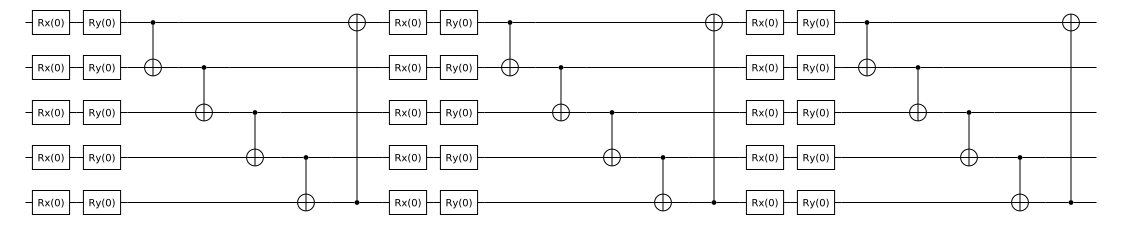

In [9]:
YaoPlots.plot(VQE(5, 3))

**VQE от Yao.jl**

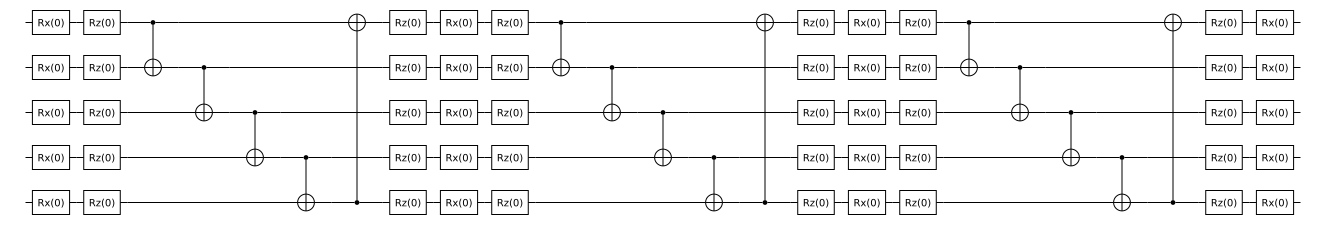

In [10]:
YaoPlots.plot(variational_circuit(5, 3))

**QAOA-вдохновленный VQE (параметры не связаны, как это должно быть)**

In [11]:
function QAOA(N::Int, d::Int)
	blocks = Any[]
	for i in 1:d
		for j in N:-1:1
			for k in (j+1):N
				push!(blocks, cnot(N, (j), k))
				push!(blocks, put(N, k => Rz(0)))
				push!(blocks, cnot(N, (j), k))
			end
		end
		for j in 1:N
			push!(blocks, put(N, j => Rz(0)))
			push!(blocks, put(N, j => Rx(0)))
		end
	end
	return chain(blocks)
end

QAOA (generic function with 1 method)

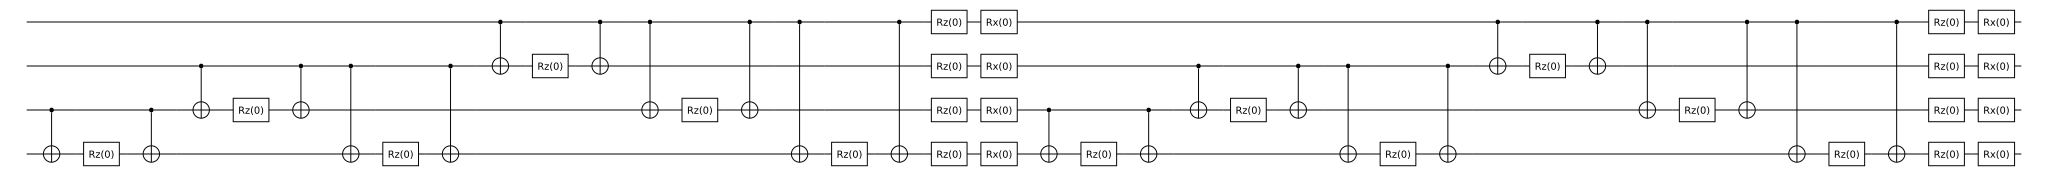

In [12]:
YaoPlots.plot(QAOA(4, 2))

**QAOA через TimeEvolution**

In [13]:
function TQAOA(N::Int, d::Int, Hc, Hm)
	blocks = Any[]
	for i in 1:d
		push!(blocks, TimeEvolution(Hc, 2*pi))
		push!(blocks, TimeEvolution(Hm, 2*pi))
	end
	return chain(blocks) # теперь параметры можно получить через `parameters(circ)` 
end

TQAOA (generic function with 1 method)

Участок кода для расчета доли "сошедшихся" цепей. Максимальное количество итераций рассчитывается как  $10\sigma$ от пробного запуска (с максимумом в 10000)

8...9...10...11...12...13...14...15...16...

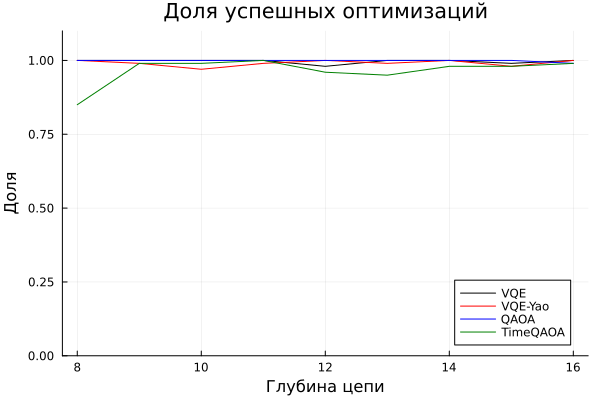

In [14]:
N = 3
sp1, sp2, sp3, sp4 = [], [], [], []
depths = 2^(N):(2^(N+1))

for i in depths
	iterations_VQE = get_statistics(N, i, 12, VQE, zero_state, 10000, false)[2]
	iterations_VQEjl = get_statistics(N, i, 12, variational_circuit, zero_state, 10000, false)[2]
	iterations_QAOA = get_statistics(N, i, 12, QAOA, uniform_state, 10000, false)[2]
	iterations_TQAOA = get_statistics(N, i, 12, TQAOA, uniform_state, 10000, false)[2]

	i1 = round(Int, mean(iterations_VQE) + 10 * std(iterations_VQE))
	i2 = round(Int, mean(iterations_VQEjl) + 10 * std(iterations_VQEjl))
	i3 = round(Int, mean(iterations_QAOA) + 10 * std(iterations_QAOA))
	i4 = round(Int, mean(iterations_TQAOA) + 10 * std(iterations_TQAOA))

	res_VQE = get_statistics(N, i, 100, VQE, zero_state, i1, false)[1]
	res_VQEjl = get_statistics(N, i, 100, variational_circuit, zero_state, i2, false)[1]
	res_QAOA = get_statistics(N, i, 100, QAOA, uniform_state, i3, false)[1]
	res_TQAOA = get_statistics(N, i, 100, TQAOA, uniform_state, i4, false)[1]

	push!(sp1, res_VQE)
	push!(sp2, res_VQEjl)
	push!(sp3, res_QAOA)
	push!(sp4, res_TQAOA)

	print("$i...")
end

StatsPlots.plot(depths, sp1, ylim = (0, 1.1), title = "Доля успешных оптимизаций", xlabel = "Глубина цепи", ylabel = "Доля", label = "VQE", color = :black)
StatsPlots.plot!(depths, sp2, label = "VQE-Yao", color = :red)
StatsPlots.plot!(depths, sp3, label = "QAOA", color = :blue)
StatsPlots.plot!(depths, sp4, label = "TimeQAOA", color = :green)


Из-за слишком долгой работы, полноценный QAOA реализованный с помощью блоков TimeEvolution далее не будет рассматриваться, однако, в целом, видно, что все представленные анзацы для VQE на большой глубине сходятся к правильному решению в подавляющем большинстве случаев.

Надо сказать, что пока рассматриваются цепи с малым количеством кубит по той причине, что цепи с большим количеством кубит еще менее вероятно сойдутся на малой глубине, что не позволит нарисовать график.

1...

2...3...4...5...6...7...8...9...10...

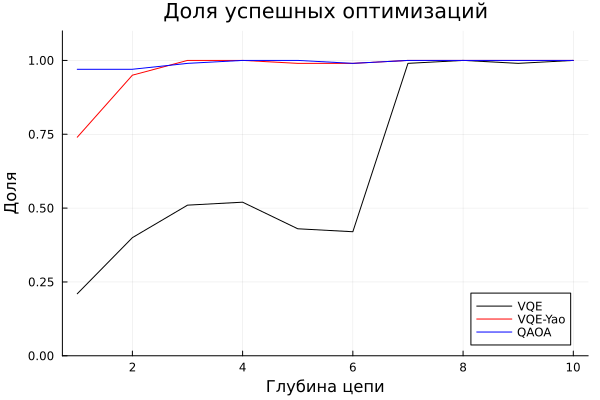

In [15]:
N = 3
sp1, sp2, sp3 = [], [], []
depths = 1:10

for i in depths
	iterations_VQE = get_statistics(N, i, 24, VQE, zero_state, 10000, false)[2]
	iterations_VQEjl = get_statistics(N, i, 24, variational_circuit, zero_state, 10000, false)[2]
	iterations_QAOA = get_statistics(N, i, 24, QAOA, uniform_state, 10000, false)[2]

	i1 = round(Int, mean(iterations_VQE) + 10 * std(iterations_VQE))
	i2 = round(Int, mean(iterations_VQEjl) + 10 * std(iterations_VQEjl))
	i3 = round(Int, mean(iterations_QAOA) + 10 * std(iterations_QAOA))

	res_VQE = get_statistics(N, i, 100, VQE, zero_state, i1, false)[1]
	res_VQEjl = get_statistics(N, i, 100, variational_circuit, zero_state, i2, false)[1]
	res_QAOA = get_statistics(N, i, 100, QAOA, uniform_state, i3, false)[1]

	push!(sp1, res_VQE)
	push!(sp2, res_VQEjl)
	push!(sp3, res_QAOA)

	print("$i...")
end

StatsPlots.plot(depths, sp1, ylim = (0, 1.1), title = "Доля успешных оптимизаций", xlabel = "Глубина цепи", ylabel = "Доля", label = "VQE", color = :black)
StatsPlots.plot!(depths, sp2, label = "VQE-Yao", color = :red)
StatsPlots.plot!(depths, sp3, label = "QAOA", color = :blue)

Видно, что классический VQE требует глубину цепи для гарантированной сходимости в $2^n$, тогда как алгоритмы более похожие на QAOA требуют меньшую глубину цепи для того же.
Проверим данное утверждение.

3...

4...5...6...7...8...

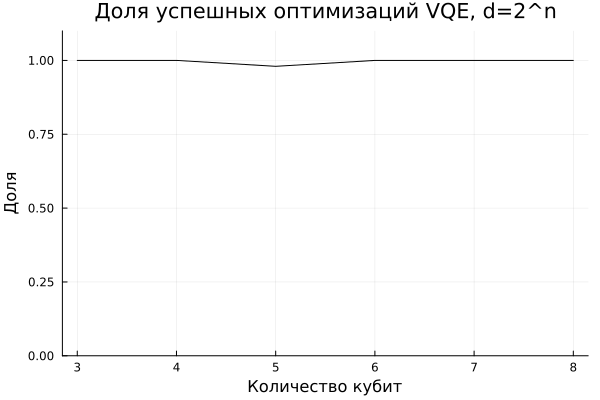

In [16]:
sp = []
num_qubits = 3:8

for i in num_qubits
	iterations_VQE = get_statistics(i, 2^i, 24, VQE, zero_state, 10000, false)[2]
	i1 = round(Int, mean(iterations_VQE) + 10 * std(iterations_VQE))
	res_VQE = get_statistics(i, 2^i, 100, VQE, zero_state, i1, false)[1]
	push!(sp, res_VQE)
	print("$i...")
end

plot0 = StatsPlots.plot(num_qubits, sp, ylim = (0, 1.1), title = "Доля успешных оптимизаций VQE, d=2^n", xlabel = "Количество кубит", ylabel = "Доля", legend=false, color = :black)
display(plot0)

3...4...5...6...7...8...

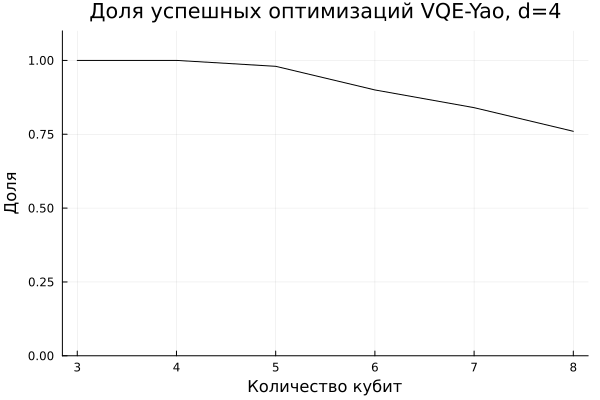

In [26]:
sp = []
num_qubits = 3:8

for i in num_qubits
	iterations_VQE = get_statistics(i, 4, 12, variational_circuit, zero_state, 10000, false)[2]
	i1 = round(Int, mean(iterations_VQE) + 10 * std(iterations_VQE))
	res_VQE = get_statistics(i, 4, 100, variational_circuit, zero_state, i1, false)[1]
	push!(sp, res_VQE)
	print("$i...")
end

plot0 = StatsPlots.plot(num_qubits, sp, ylim = (0, 1.1), title = "Доля успешных оптимизаций VQE-Yao, d=4", xlabel = "Количество кубит", ylabel = "Доля", legend=false, color = :black)
display(plot0)

3...4...5...6...

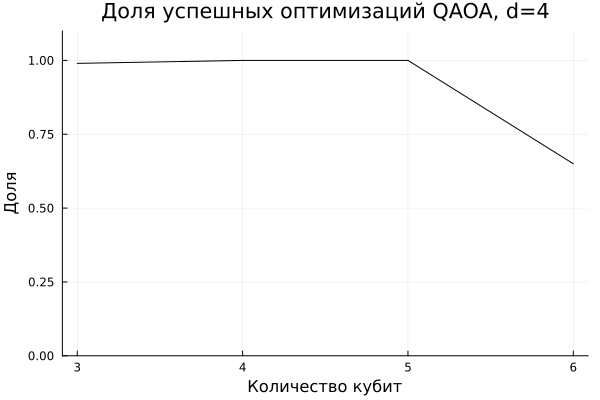

In [30]:
sp = []
num_qubits = 3:6

for i in num_qubits
	iterations_VQE = get_statistics(i, 4, 12, QAOA, uniform_state, 10000, false)[2]
	i1 = round(Int, mean(iterations_VQE) + 10 * std(iterations_VQE))
	res_VQE = get_statistics(i, 4, 100, QAOA, uniform_state, i1, false)[1]
	push!(sp, res_VQE)
	print("$i...")
end

plot0 = StatsPlots.plot(num_qubits, sp, ylim = (0, 1.1), title = "Доля успешных оптимизаций QAOA, d=4", xlabel = "Количество кубит", ylabel = "Доля", legend=false, color = :black)
display(plot0)

Бонусно: сравнение (не)эффективности моделирования через полнокубитный унитарный оператор:

In [18]:
println("Гейтовый QAOA")
get_statistics(3, 8, 24, QAOA, uniform_state, 1000)
println("QAOA через TimeEvolution")
get_statistics(3, 8, 24, TQAOA, uniform_state, 1000)

Гейтовый QAOA
Цепь с 3 кубитами и глубиной 8
	Количество итераций: 61.208333333333336 ± 22.62737696697956
	Вероятность успешной оптимизации: 1.0
	Время оптимизации: 0.05144152045249939 ± 0.023278204639370907
	Время расчета наблюдаемой: 9.195009867350261e-5 ± 0.00014464435612017212
	Время расчета градиента: 0.00017934044202168783 ± 0.00019595468470239583
	Время итерации: 0.0008851002346201811 ± 0.00044773618530714437

QAOA через TimeEvolution
Цепь с 3 кубитами и глубиной 8
	Количество итераций: 248.2 ± 187.83099906705047
	Вероятность успешной оптимизации: 0.8333333333333334
	Время оптимизации: 3.3182130217552186 ± 2.3159423370158083
	Время расчета наблюдаемой: 0.003515744209289551 ± 0.0033749067173169515
	Время расчета градиента: 0.01029829978942871 ± 0.0069059239382792195
	Время итерации: 0.014202216643415913 ± 0.002579680229749243



(0.8333333333333334, [111, 126, 370, 124, 228, 380, 251, 222, 99, 687, 138, 151, 244, 282, 342, 763, 115, 101, 87, 143], [0.0037021636962890625, 0.0028960704803466797, 0.0071179866790771484, 0.0035400390625, 0.0012159347534179688, 0.0042569637298583984, 0.0022139549255371094, 0.002424955368041992, 0.001544952392578125, 0.0014109611511230469, 0.006825923919677734, 0.003972053527832031, 0.0016028881072998047, 0.015945911407470703, 0.0016820430755615234, 0.003017902374267578, 0.002254009246826172, 0.0015368461608886719, 0.0015251636505126953, 0.0016281604766845703], [0.007027864456176758, 0.006283998489379883, 0.007662057876586914, 0.020350933074951172, 0.0039081573486328125, 0.014752864837646484, 0.004874229431152344, 0.009021997451782227, 0.006034135818481445, 0.004116058349609375, 0.007179975509643555, 0.023953914642333984, 0.005638837814331055, 0.008352994918823242, 0.0048749446868896484, 0.005625009536743164, 0.021239042282104492, 0.02113509178161621, 0.004633903503417969, 0.01929998